In [1]:
!nvidia-smi

Fri May 20 15:35:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 28%   54C    P8    27W / 300W |   3209MiB / 11264MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip -q install timm

In [3]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
# from samples.CLS2IDX import CLS2IDX

#ViT Code

In [ ]:
import torch
# check you have the right version of timm
import timm
# assert timm.__version__ == "0.3.2"

# now load it with torchhub
modelVit = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
# modelVit = torch.hub.load('facebookresearch/deit:main', 'deit_small_patch16_224', pretrained=True)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


#Swin code

##old

In [ ]:
# # --------------------------------------------------------
# # Swin Transformer
# # Copyright (c) 2021 Microsoft
# # Licensed under The MIT License [see LICENSE for details]
# # Written by Ze Liu, Yutong Lin, Yixuan Wei
# # --------------------------------------------------------

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.utils.checkpoint as checkpoint
# import numpy as np
# from timm.models.layers import DropPath, to_2tuple, trunc_normal_


# # from mmcv_custom import load_checkpoint
# # from mmdet.utils import get_root_logger
# def _cfg(url='', **kwargs):
#     return {
#         'url': url,
#         'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
#         'crop_pct': .9, 'interpolation': 'bicubic',
#         'first_conv': 'patch_embed.proj', 'classifier': 'head',
#         **kwargs
#     }


# class Mlp(nn.Module):
#     def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
#         super().__init__()
#         out_features = out_features or in_features
#         hidden_features = hidden_features or in_features
#         self.fc1 = nn.Linear(in_features, hidden_features)
#         self.act = act_layer()
#         self.fc2 = nn.Linear(hidden_features, out_features)
#         self.drop = nn.Dropout(drop)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.act(x)
#         x = self.drop(x)
#         x = self.fc2(x)
#         x = self.drop(x)
#         return x


# def window_partition(x, window_size):
#     """
#     Args:
#         x: (B, H, W, C)
#         window_size (int): window size
#     Returns:
#         windows: (num_windows*B, window_size, window_size, C)
#     """
#     B, H, W, C = x.shape
#     x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
#     windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
#     return windows


# def window_reverse(windows, window_size, H, W):
#     """
#     Args:
#         windows: (num_windows*B, window_size, window_size, C)
#         window_size (int): Window size
#         H (int): Height of image
#         W (int): Width of image
#     Returns:
#         x: (B, H, W, C)
#     """
#     B = int(windows.shape[0] / (H * W / window_size / window_size))
#     x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
#     x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
#     return x


# class WindowAttention(nn.Module):
#     r""" Window based multi-head self attention (W-MSA) module with relative position bias.
#     It supports both of shifted and non-shifted window.
#     Args:
#         dim (int): Number of input channels.
#         window_size (tuple[int]): The height and width of the window.
#         num_heads (int): Number of attention heads.
#         qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
#         qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
#         attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
#         proj_drop (float, optional): Dropout ratio of output. Default: 0.0
#     """

#     def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

#         super().__init__()
#         self.dim = dim
#         self.window_size = window_size  # Wh, Ww
#         self.num_heads = num_heads
#         head_dim = dim // num_heads
#         self.scale = qk_scale or head_dim ** -0.5

#         # define a parameter table of relative position bias
#         self.relative_position_bias_table = nn.Parameter(
#             torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

#         # get pair-wise relative position index for each token inside the window
#         coords_h = torch.arange(self.window_size[0])
#         coords_w = torch.arange(self.window_size[1])
#         coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
#         coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
#         relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
#         relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
#         relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
#         relative_coords[:, :, 1] += self.window_size[1] - 1
#         relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
#         relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
#         self.register_buffer("relative_position_index", relative_position_index)

#         self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
#         self.attn_drop = nn.Dropout(attn_drop)
#         self.proj = nn.Linear(dim, dim)
#         self.proj_drop = nn.Dropout(proj_drop)

#         trunc_normal_(self.relative_position_bias_table, std=.02)
#         self.softmax = nn.Softmax(dim=-1)

#     def forward(self, x, mask=None):
#         """
#         Args:
#             x: input features with shape of (num_windows*B, N, C)
#             mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
#         """
#         B_, N, C = x.shape
#         qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
#         q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

#         q = q * self.scale
#         attn = (q @ k.transpose(-2, -1))

#         relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
#             self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
#         relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
#         attn = attn + relative_position_bias.unsqueeze(0)

#         if mask is not None:
#             nW = mask.shape[0]
#             attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
#             attn = attn.view(-1, self.num_heads, N, N)
#             attn = self.softmax(attn)
#         else:
#             attn = self.softmax(attn)

#         attn = self.attn_drop(attn)

#         x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
#         x = self.proj(x)
#         x = self.proj_drop(x)
#         return x

#     def extra_repr(self) -> str:
#         return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

#     def flops(self, N):
#         # calculate flops for 1 window with token length of N
#         flops = 0
#         # qkv = self.qkv(x)
#         flops += N * self.dim * 3 * self.dim
#         # attn = (q @ k.transpose(-2, -1))
#         flops += self.num_heads * N * (self.dim // self.num_heads) * N
#         #  x = (attn @ v)
#         flops += self.num_heads * N * N * (self.dim // self.num_heads)
#         # x = self.proj(x)
#         flops += N * self.dim * self.dim
#         return flops


# class SwinTransformerBlock(nn.Module):
#     r""" Swin Transformer Block.
#     Args:
#         dim (int): Number of input channels.
#         input_resolution (tuple[int]): Input resulotion.
#         num_heads (int): Number of attention heads.
#         window_size (int): Window size.
#         shift_size (int): Shift size for SW-MSA.
#         mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
#         qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
#         qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
#         drop (float, optional): Dropout rate. Default: 0.0
#         attn_drop (float, optional): Attention dropout rate. Default: 0.0
#         drop_path (float, optional): Stochastic depth rate. Default: 0.0
#         act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
#         norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
#     """

#     def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
#                  mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
#                  act_layer=nn.GELU, norm_layer=nn.LayerNorm):
#         super().__init__()
#         self.dim = dim
#         self.input_resolution = input_resolution
#         self.num_heads = num_heads
#         self.window_size = window_size
#         self.shift_size = shift_size
#         self.mlp_ratio = mlp_ratio
#         if min(self.input_resolution) <= self.window_size:
#             # if window size is larger than input resolution, we don't partition windows
#             self.shift_size = 0
#             self.window_size = min(self.input_resolution)
#         assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

#         self.norm1 = norm_layer(dim)
#         self.attn = WindowAttention(
#             dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
#             qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

#         self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
#         self.norm2 = norm_layer(dim)
#         mlp_hidden_dim = int(dim * mlp_ratio)
#         self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

#         if self.shift_size > 0:
#             # calculate attention mask for SW-MSA
#             H, W = self.input_resolution
#             img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
#             h_slices = (slice(0, -self.window_size),
#                         slice(-self.window_size, -self.shift_size),
#                         slice(-self.shift_size, None))
#             w_slices = (slice(0, -self.window_size),
#                         slice(-self.window_size, -self.shift_size),
#                         slice(-self.shift_size, None))
#             cnt = 0
#             for h in h_slices:
#                 for w in w_slices:
#                     img_mask[:, h, w, :] = cnt
#                     cnt += 1

#             mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
#             mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
#             attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
#             attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
#         else:
#             attn_mask = None

#         self.register_buffer("attn_mask", attn_mask)

#     def forward(self, x):
#         H, W = self.input_resolution
#         B, L, C = x.shape
#         assert L == H * W, "input feature has wrong size"

#         shortcut = x
#         x = self.norm1(x)
#         x = x.view(B, H, W, C)

#         # cyclic shift
#         if self.shift_size > 0:
#             shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
#         else:
#             shifted_x = x

#         # partition windows
#         x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
#         x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

#         # W-MSA/SW-MSA
#         attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

#         # merge windows
#         attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
#         shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

#         # reverse cyclic shift
#         if self.shift_size > 0:
#             x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
#         else:
#             x = shifted_x
#         x = x.view(B, H * W, C)

#         # FFN
#         x = shortcut + self.drop_path(x)
#         x = x + self.drop_path(self.mlp(self.norm2(x)))

#         return x

#     def extra_repr(self) -> str:
#         return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
#                f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

#     def flops(self):
#         flops = 0
#         H, W = self.input_resolution
#         # norm1
#         flops += self.dim * H * W
#         # W-MSA/SW-MSA
#         nW = H * W / self.window_size / self.window_size
#         flops += nW * self.attn.flops(self.window_size * self.window_size)
#         # mlp
#         flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
#         # norm2
#         flops += self.dim * H * W
#         return flops


# class PatchMerging(nn.Module):
#     r""" Patch Merging Layer.
#     Args:
#         input_resolution (tuple[int]): Resolution of input feature.
#         dim (int): Number of input channels.
#         norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
#     """

#     def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
#         super().__init__()
#         self.input_resolution = input_resolution
#         self.dim = dim
#         self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
#         self.norm = norm_layer(4 * dim)

#     def forward(self, x):
#         """
#         x: B, H*W, C
#         """
#         H, W = self.input_resolution
#         B, L, C = x.shape
#         assert L == H * W, "input feature has wrong size"
#         assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

#         x = x.view(B, H, W, C)

#         x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
#         x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
#         x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
#         x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
#         x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
#         x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

#         x = self.norm(x)
#         x = self.reduction(x)

#         return x

#     def extra_repr(self) -> str:
#         return f"input_resolution={self.input_resolution}, dim={self.dim}"

#     def flops(self):
#         H, W = self.input_resolution
#         flops = H * W * self.dim
#         flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
#         return flops


# class BasicLayer(nn.Module):
#     """ A basic Swin Transformer layer for one stage.
#     Args:
#         dim (int): Number of input channels.
#         input_resolution (tuple[int]): Input resolution.
#         depth (int): Number of blocks.
#         num_heads (int): Number of attention heads.
#         window_size (int): Local window size.
#         mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
#         qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
#         qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
#         drop (float, optional): Dropout rate. Default: 0.0
#         attn_drop (float, optional): Attention dropout rate. Default: 0.0
#         drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
#         norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
#         downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
#         use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
#     """

#     def __init__(self, dim, input_resolution, depth, num_heads, window_size,
#                  mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
#                  drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

#         super().__init__()
#         self.dim = dim
#         self.input_resolution = input_resolution
#         self.depth = depth
#         self.use_checkpoint = use_checkpoint

#         # build blocks
#         self.blocks = nn.ModuleList([
#             SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
#                                  num_heads=num_heads, window_size=window_size,
#                                  shift_size=0 if (i % 2 == 0) else window_size // 2,
#                                  mlp_ratio=mlp_ratio,
#                                  qkv_bias=qkv_bias, qk_scale=qk_scale,
#                                  drop=drop, attn_drop=attn_drop,
#                                  drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
#                                  norm_layer=norm_layer)
#             for i in range(depth)])

#         # patch merging layer
#         if downsample is not None:
#             self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
#         else:
#             self.downsample = None

#     def forward(self, x):
#         for blk in self.blocks:
#             if self.use_checkpoint:
#                 x = checkpoint.checkpoint(blk, x)
#             else:
#                 x = blk(x)
#         if self.downsample is not None:
#             x = self.downsample(x)
#         return x

#     def extra_repr(self) -> str:
#         return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

#     def flops(self):
#         flops = 0
#         for blk in self.blocks:
#             flops += blk.flops()
#         if self.downsample is not None:
#             flops += self.downsample.flops()
#         return flops


# class PatchEmbed(nn.Module):
#     r""" Image to Patch Embedding
#     Args:
#         img_size (int): Image size.  Default: 224.
#         patch_size (int): Patch token size. Default: 4.
#         in_chans (int): Number of input image channels. Default: 3.
#         embed_dim (int): Number of linear projection output channels. Default: 96.
#         norm_layer (nn.Module, optional): Normalization layer. Default: None
#     """

#     def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
#         super().__init__()
#         img_size = to_2tuple(img_size)
#         patch_size = to_2tuple(patch_size)
#         patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
#         self.img_size = img_size
#         self.patch_size = patch_size
#         self.patches_resolution = patches_resolution
#         self.num_patches = patches_resolution[0] * patches_resolution[1]

#         self.in_chans = in_chans
#         self.embed_dim = embed_dim

#         self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
#         if norm_layer is not None:
#             self.norm = norm_layer(embed_dim)
#         else:
#             self.norm = None

#     def forward(self, x):
#         B, C, H, W = x.shape
#         # FIXME look at relaxing size constraints
#         assert H == self.img_size[0] and W == self.img_size[1], \
#             f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
#         x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
#         if self.norm is not None:
#             x = self.norm(x)
#         return x

#     def flops(self):
#         Ho, Wo = self.patches_resolution
#         flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
#         if self.norm is not None:
#             flops += Ho * Wo * self.embed_dim
#         return flops


# class SwinTransformer(nn.Module):
#     r""" Swin Transformer
#         A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
#           https://arxiv.org/pdf/2103.14030
#     Args:
#         img_size (int | tuple(int)): Input image size. Default 224
#         patch_size (int | tuple(int)): Patch size. Default: 4
#         in_chans (int): Number of input image channels. Default: 3
#         num_classes (int): Number of classes for classification head. Default: 1000
#         embed_dim (int): Patch embedding dimension. Default: 96
#         depths (tuple(int)): Depth of each Swin Transformer layer.
#         num_heads (tuple(int)): Number of attention heads in different layers.
#         window_size (int): Window size. Default: 7
#         mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
#         qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
#         qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
#         drop_rate (float): Dropout rate. Default: 0
#         attn_drop_rate (float): Attention dropout rate. Default: 0
#         drop_path_rate (float): Stochastic depth rate. Default: 0.1
#         norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
#         ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
#         patch_norm (bool): If True, add normalization after patch embedding. Default: True
#         use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
#     """

#     def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
#                  embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
#                  window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
#                  drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
#                  norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
#                  use_checkpoint=False, **kwargs):
#         super().__init__()

#         self.num_classes = num_classes
#         self.num_layers = len(depths)
#         self.embed_dim = embed_dim
#         self.ape = ape
#         self.patch_norm = patch_norm
#         self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
#         self.mlp_ratio = mlp_ratio

#         # split image into non-overlapping patches
#         self.patch_embed = PatchEmbed(
#             img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
#             norm_layer=norm_layer if self.patch_norm else None)
#         num_patches = self.patch_embed.num_patches
#         patches_resolution = self.patch_embed.patches_resolution
#         self.patches_resolution = patches_resolution

#         # absolute position embedding
#         if self.ape:
#             self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
#             trunc_normal_(self.absolute_pos_embed, std=.02)

#         self.pos_drop = nn.Dropout(p=drop_rate)

#         # stochastic depth
#         dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

#         # build layers
#         self.layers = nn.ModuleList()
#         for i_layer in range(self.num_layers):
#             layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
#                                input_resolution=(patches_resolution[0] // (2 ** i_layer),
#                                                  patches_resolution[1] // (2 ** i_layer)),
#                                depth=depths[i_layer],
#                                num_heads=num_heads[i_layer],
#                                window_size=window_size,
#                                mlp_ratio=self.mlp_ratio,
#                                qkv_bias=qkv_bias, qk_scale=qk_scale,
#                                drop=drop_rate, attn_drop=attn_drop_rate,
#                                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
#                                norm_layer=norm_layer,
#                                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
#                                use_checkpoint=use_checkpoint)
#             self.layers.append(layer)

#         self.norm = norm_layer(self.num_features)
#         self.avgpool = nn.AdaptiveAvgPool1d(1)
#         self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

#         self.apply(self._init_weights)

#     def _init_weights(self, m):
#         if isinstance(m, nn.Linear):
#             trunc_normal_(m.weight, std=.02)
#             if isinstance(m, nn.Linear) and m.bias is not None:
#                 nn.init.constant_(m.bias, 0)
#         elif isinstance(m, nn.LayerNorm):
#             nn.init.constant_(m.bias, 0)
#             nn.init.constant_(m.weight, 1.0)

#     @torch.jit.ignore
#     def no_weight_decay(self):
#         return {'absolute_pos_embed'}

#     @torch.jit.ignore
#     def no_weight_decay_keywords(self):
#         return {'relative_position_bias_table'}

#     def forward_features(self, x):
#         x = self.patch_embed(x)
#         if self.ape:
#             x = x + self.absolute_pos_embed
#         x = self.pos_drop(x)

#         for layer in self.layers:
#             x = layer(x)

#         x = self.norm(x)  # B L C
#         x = self.avgpool(x.transpose(1, 2))  # B C 1
#         x = torch.flatten(x, 1)
#         return x

#     def forward(self, x):
#         x = self.forward_features(x)
#         x = self.head(x)
#         return x

#     def flops(self):
#         flops = 0
#         flops += self.patch_embed.flops()
#         for i, layer in enumerate(self.layers):
#             flops += layer.flops()
#         flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
#         flops += self.num_features * self.num_classes
#         return flops

# def swin_t_patch4_224(pretrained=False, **kwargs):
#     model = SwinTransformer()
#         # patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True, **kwargs)
#     model.default_cfg = _cfg()
#     if pretrained:
#         # checkpoint = torch.hub.load_state_dict_from_url(
#         #     url="https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth",
#         #     map_location="cpu", check_hash=True
#         # )
#         # logger.info(f"==============> Loading weight {config.MODEL.PRETRAINED} for fine-tuning......")
#         # model.load_state_dict(torch.load(r"D:\Users\Giles\Downloads\swin_tiny_patch4_window7_224.pth"))#checkpoint["model"])
#         #r"D:\Users\Giles\Downloads\swin_tiny_patch4_window7_224.pth"
#         checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224.pth", map_location='cpu')
#         state_dict = checkpoint['model']

#         # delete relative_position_index since we always re-init it
#         relative_position_index_keys = [k for k in state_dict.keys() if "relative_position_index" in k]
#         for k in relative_position_index_keys:
#             del state_dict[k]

#         # delete relative_coords_table since we always re-init it
#         relative_position_index_keys = [k for k in state_dict.keys() if "relative_coords_table" in k]
#         for k in relative_position_index_keys:
#             del state_dict[k]

#         # delete attn_mask since we always re-init it
#         attn_mask_keys = [k for k in state_dict.keys() if "attn_mask" in k]
#         for k in attn_mask_keys:
#             del state_dict[k]

#         # bicubic interpolate relative_position_bias_table if not match
#         relative_position_bias_table_keys = [k for k in state_dict.keys() if "relative_position_bias_table" in k]
#         for k in relative_position_bias_table_keys:
#             relative_position_bias_table_pretrained = state_dict[k]
#             relative_position_bias_table_current = model.state_dict()[k]
#             L1, nH1 = relative_position_bias_table_pretrained.size()
#             L2, nH2 = relative_position_bias_table_current.size()
#             if nH1 != nH2:
#                 print(f"Error in loading {k}, passing......")# logger.warning(f"Error in loading {k}, passing......")
#             else:
#                 if L1 != L2:
#                     # bicubic interpolate relative_position_bias_table if not match
#                     S1 = int(L1 ** 0.5)
#                     S2 = int(L2 ** 0.5)
#                     relative_position_bias_table_pretrained_resized = torch.nn.functional.interpolate(
#                         relative_position_bias_table_pretrained.permute(1, 0).view(1, nH1, S1, S1), size=(S2, S2),
#                         mode='bicubic')
#                     state_dict[k] = relative_position_bias_table_pretrained_resized.view(nH2, L2).permute(1, 0)

#         # bicubic interpolate absolute_pos_embed if not match
#         absolute_pos_embed_keys = [k for k in state_dict.keys() if "absolute_pos_embed" in k]
#         for k in absolute_pos_embed_keys:
#             # dpe
#             absolute_pos_embed_pretrained = state_dict[k]
#             absolute_pos_embed_current = model.state_dict()[k]
#             _, L1, C1 = absolute_pos_embed_pretrained.size()
#             _, L2, C2 = absolute_pos_embed_current.size()
#             if C1 != C1:
#                 print(f"Error in loading {k}, passing......")#logger.warning(f"Error in loading {k}, passing......")
#             else:
#                 if L1 != L2:
#                     S1 = int(L1 ** 0.5)
#                     S2 = int(L2 ** 0.5)
#                     absolute_pos_embed_pretrained = absolute_pos_embed_pretrained.reshape(-1, S1, S1, C1)
#                     absolute_pos_embed_pretrained = absolute_pos_embed_pretrained.permute(0, 3, 1, 2)
#                     absolute_pos_embed_pretrained_resized = torch.nn.functional.interpolate(
#                         absolute_pos_embed_pretrained, size=(S2, S2), mode='bicubic')
#                     absolute_pos_embed_pretrained_resized = absolute_pos_embed_pretrained_resized.permute(0, 2, 3, 1)
#                     absolute_pos_embed_pretrained_resized = absolute_pos_embed_pretrained_resized.flatten(1, 2)
#                     state_dict[k] = absolute_pos_embed_pretrained_resized

#         # check classifier, if not match, then re-init classifier to zero
#         head_bias_pretrained = state_dict['head.bias']
#         Nc1 = head_bias_pretrained.shape[0]
#         Nc2 = model.head.bias.shape[0]
#         if (Nc1 != Nc2):
#             if Nc1 == 21841 and Nc2 == 1000:
#                 print("loading ImageNet-22K weight to ImageNet-1K ......")#logger.info("loading ImageNet-22K weight to ImageNet-1K ......")
#                 map22kto1k_path = f'data/map22kto1k.txt'
#                 with open(map22kto1k_path) as f:
#                     map22kto1k = f.readlines()
#                 map22kto1k = [int(id22k.strip()) for id22k in map22kto1k]
#                 state_dict['head.weight'] = state_dict['head.weight'][map22kto1k, :]
#                 state_dict['head.bias'] = state_dict['head.bias'][map22kto1k]
#             else:
#                 torch.nn.init.constant_(model.head.bias, 0.)
#                 torch.nn.init.constant_(model.head.weight, 0.)
#                 del state_dict['head.weight']
#                 del state_dict['head.bias']
#                 logger.warning(f"Error in loading classifier head, re-init classifier head to 0")

#         msg = model.load_state_dict(state_dict, strict=False)
#         print(msg)#logger.warning(msg)

#         print(f"=> loaded successfully swin_tiny_patch4_window7_224.pth'")#logger.info(f"=> loaded successfully '{config.MODEL.PRETRAINED}'")

#         del checkpoint
#         torch.cuda.empty_cache()
#     return model

##new

In [4]:
# --------------------------------------------------------
# Swin Transformer
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ze Liu, Yutong Lin, Yixuan Wei
# --------------------------------------------------------

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
import numpy as np
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


# from mmcv_custom import load_checkpoint
# from mmdet.utils import get_root_logger
# def _cfg(url='', **kwargs):
#     return {
#         'url': url,
#         'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
#         'crop_pct': .9, 'interpolation': 'bicubic',
#         'first_conv': 'patch_embed.proj', 'classifier': 'head',
#         **kwargs
#     }


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030
    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

def swin_t_patch4_224(pretrained=False, **kwargs):
    model = SwinTransformer()
        # patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True, **kwargs)
    # model.default_cfg = _cfg()
    if pretrained:
        # checkpoint = torch.hub.load_state_dict_from_url(
        #     url="https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth",
        #     map_location="cpu", check_hash=True
        # )
        # logger.info(f"==============> Loading weight {config.MODEL.PRETRAINED} for fine-tuning......")
        # model.load_state_dict(torch.load(r"D:\Users\Giles\Downloads\swin_tiny_patch4_window7_224.pth"))#checkpoint["model"])
        #r"D:\Users\Giles\Downloads\swin_tiny_patch4_window7_224.pth"
        checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224.pth", map_location='cpu')
        state_dict = checkpoint['model']

        # # delete relative_position_index since we always re-init it
        # relative_position_index_keys = [k for k in state_dict.keys() if "relative_position_index" in k]
        # for k in relative_position_index_keys:
        #     del state_dict[k]

        # # delete relative_coords_table since we always re-init it
        # relative_position_index_keys = [k for k in state_dict.keys() if "relative_coords_table" in k]
        # for k in relative_position_index_keys:
        #     del state_dict[k]

        # # delete attn_mask since we always re-init it
        # attn_mask_keys = [k for k in state_dict.keys() if "attn_mask" in k]
        # for k in attn_mask_keys:
        #     del state_dict[k]

        # # bicubic interpolate relative_position_bias_table if not match
        # relative_position_bias_table_keys = [k for k in state_dict.keys() if "relative_position_bias_table" in k]
        # for k in relative_position_bias_table_keys:
        #     relative_position_bias_table_pretrained = state_dict[k]
        #     relative_position_bias_table_current = model.state_dict()[k]
        #     L1, nH1 = relative_position_bias_table_pretrained.size()
        #     L2, nH2 = relative_position_bias_table_current.size()
        #     if nH1 != nH2:
        #         print(f"Error in loading {k}, passing......")# logger.warning(f"Error in loading {k}, passing......")
        #     else:
        #         if L1 != L2:
        #             # bicubic interpolate relative_position_bias_table if not match
        #             S1 = int(L1 ** 0.5)
        #             S2 = int(L2 ** 0.5)
        #             relative_position_bias_table_pretrained_resized = torch.nn.functional.interpolate(
        #                 relative_position_bias_table_pretrained.permute(1, 0).view(1, nH1, S1, S1), size=(S2, S2),
        #                 mode='bicubic')
        #             state_dict[k] = relative_position_bias_table_pretrained_resized.view(nH2, L2).permute(1, 0)

        # # bicubic interpolate absolute_pos_embed if not match
        # absolute_pos_embed_keys = [k for k in state_dict.keys() if "absolute_pos_embed" in k]
        # for k in absolute_pos_embed_keys:
        #     # dpe
        #     absolute_pos_embed_pretrained = state_dict[k]
        #     absolute_pos_embed_current = model.state_dict()[k]
        #     _, L1, C1 = absolute_pos_embed_pretrained.size()
        #     _, L2, C2 = absolute_pos_embed_current.size()
        #     if C1 != C1:
        #         print(f"Error in loading {k}, passing......")#logger.warning(f"Error in loading {k}, passing......")
        #     else:
        #         if L1 != L2:
        #             S1 = int(L1 ** 0.5)
        #             S2 = int(L2 ** 0.5)
        #             absolute_pos_embed_pretrained = absolute_pos_embed_pretrained.reshape(-1, S1, S1, C1)
        #             absolute_pos_embed_pretrained = absolute_pos_embed_pretrained.permute(0, 3, 1, 2)
        #             absolute_pos_embed_pretrained_resized = torch.nn.functional.interpolate(
        #                 absolute_pos_embed_pretrained, size=(S2, S2), mode='bicubic')
        #             absolute_pos_embed_pretrained_resized = absolute_pos_embed_pretrained_resized.permute(0, 2, 3, 1)
        #             absolute_pos_embed_pretrained_resized = absolute_pos_embed_pretrained_resized.flatten(1, 2)
        #             state_dict[k] = absolute_pos_embed_pretrained_resized

        # # check classifier, if not match, then re-init classifier to zero
        # head_bias_pretrained = state_dict['head.bias']
        # Nc1 = head_bias_pretrained.shape[0]
        # Nc2 = model.head.bias.shape[0]
        # if (Nc1 != Nc2):
        #     if Nc1 == 21841 and Nc2 == 1000:
        #         print("loading ImageNet-22K weight to ImageNet-1K ......")#logger.info("loading ImageNet-22K weight to ImageNet-1K ......")
        #         map22kto1k_path = f'data/map22kto1k.txt'
        #         with open(map22kto1k_path) as f:
        #             map22kto1k = f.readlines()
        #         map22kto1k = [int(id22k.strip()) for id22k in map22kto1k]
        #         state_dict['head.weight'] = state_dict['head.weight'][map22kto1k, :]
        #         state_dict['head.bias'] = state_dict['head.bias'][map22kto1k]
        #     else:
        #         torch.nn.init.constant_(model.head.bias, 0.)
        #         torch.nn.init.constant_(model.head.weight, 0.)
        #         del state_dict['head.weight']
        #         del state_dict['head.bias']
        #         logger.warning(f"Error in loading classifier head, re-init classifier head to 0")

        msg = model.load_state_dict(state_dict, strict=False)
        print(msg)#logger.warning(msg)

        print(f"=> loaded successfully swin_tiny_patch4_window7_224.pth'")#logger.info(f"=> loaded successfully '{config.MODEL.PRETRAINED}'")

        del checkpoint
        torch.cuda.empty_cache()
    return model

def swin_t_patch4_224_diagnosis(pretrained=False, pretrainPath='', classNumber=2,**kwargs):
    model = SwinTransformer(num_classes=classNumber)
        # patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True, **kwargs)
    # model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.load(pretrainPath, map_location='cpu')
        state_dict = checkpoint['model']

        msg = model.load_state_dict(state_dict, strict=False)
        print(msg)#logger.warning(msg)

        print(f"=> loaded successfully {pretrainPath}")#logger.info(f"=> loaded successfully '{config.MODEL.PRETRAINED}'")

        del checkpoint
        torch.cuda.empty_cache()
    return model

#Create model instance

In [7]:
# from baselines.ViT.Swin import swin_t_patch4_224 as swin_t
# from baselines.ViT.ViT_explanation_generator import LRP

# initialize Swin random
modelSwin = swin_t_patch4_224(pretrained=True)#swin_t(pretrained=True)
#.cuda()
modelSwin.eval()
# attribution_generator = LRP(model)
print(modelSwin)

<All keys matched successfully>
=> loaded successfully swin_tiny_patch4_window7_224.pth'
SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax):

#Model visualisation

In [8]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=203754f7611e58d7f67023d6430c429e5aca0e274065cc2f3668e3970a774e2f
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [10]:
from torchviz import make_dot

# batch = next(iter(dataloader_train))
# x = torch.randn(1, 8)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


img = Image.open('/content/both.png')
img = img.resize((224, 224))
input_tensor = transform(img).unsqueeze(0)
y = modelSwin(input_tensor)
# yhat = model(batch.text) # Give dummy batch to forward().

make_dot(y.mean(), params=dict(list(modelSwin.named_parameters()))).render("rnn_torchviz", format="png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.872507 to fit


'rnn_torchviz.png'

In [ ]:
# from torchsummary import summary
# summary(model, input_size=(3,244,244))

# from torch.utils.tensorboard import SummaryWriter
# writer=SummaryWriter('/content/logsdir')
# %load_ext tensorboard

# # see curves in tensorboard
# %tensorboard --logdir '/content/logsdir'

#With new repo - Use Swin attention example

In [11]:
#https://github.com/jacobgil/pytorch-grad-cam
!pip -q install grad-cam

     |████████████████████████████████| 4.5 MB 16.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 796, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 796 (delta 39), reused 65 (delta 32), pack-reused 702
Receiving objects: 100% (796/796), 17.11 MiB | 13.97 MiB/s, done.
Resolving deltas: 100% (419/419), done.


In [ ]:
# !python /content/pytorch-grad-cam/usage_examples/swinT_example.py --image-path "/content/catdog.png" --use-cuda
# #Change targets to list of class

Using GPU for acceleration
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100% 32/32 [00:03<00:00,  8.65it/s]


In [1]:
!pip install yacs

In [ ]:
#Create class index dict
CLS2IDX = {0: 'Negative',
 1: 'Positive',}

In [5]:
class Object(object):
    pass
args = Object()
#GOOD:
#"eigengradcam" - level 0 good small vein details, level 2 good
#"xgradcam" - some details level 0, block 1, bit general all level 1
#"gradcam++" - attention 1, block 0
#"gradcam" - bit too general?
#"layercam" - use layer 1

#BAD:
#"eigencam"- selects everything but veins :(
#"scorecam" #bit too general, selectes other than veins
# "xgradcam" - lvl 0 blk1 ok ish :(
    
#Doesnt work:
#"fullgrad"
# "layercam"
args.method = "eigengradcam"
args.use_cuda = True
args.image_path = r"E:\Fundus images\Ch_IX_Diseases_of_Circulatory_System\val\1\1102300_21016_0_0.png"#"/content/catdog.png"#"/content/pytorch-grad-cam/examples/horses.jpg"
args.eigen_smooth = False
args.aug_smooth = False
topClassPredNum = 2#5
intrestedClasses = [1] #912 fense, 243 bull mastiv, 282 tiget cat
isPretrained = True
preTrainPath = r"E:\models\diagnosis\Ch_IX_Diseases_of_Circulatory_System\swin_tiny_patch4_window7_224\MineMOBY224\ckpt_epoch_46.pth"#"/content/ImgNetMOBY.pth"#"/content/ImgNetSupervised.pth"#"/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224.pth"#"/content/ckpt_epoch_49.pth"#
totalSwinClasses = 1000#1000#use for imagenet based models

attentionLevel = 0#0,1,2,3
blockLevel = 0#0,1

In [11]:
import argparse
import cv2
import numpy as np
import torch
import timm
import yacs
import matplotlib.pyplot as plt

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit

attentionLevelScaleFactor = 2**attentionLevel#want to divide by 2 for each level from 0
size = int(56 / attentionLevelScaleFactor if attentionLevelScaleFactor else 56)#avoid /0 error
print("transformed size:",size)

def reshape_transform(tensor, height=size, width=size):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


# if __name__ == '__main__':
""" python swinT_example.py -image-path <path_to_image>
Example usage of using cam-methods on a SwinTransformers network.
"""

# args = get_args()
methods = \
    {"gradcam": GradCAM,
      "scorecam": ScoreCAM,
      "gradcam++": GradCAMPlusPlus,
      "ablationcam": AblationCAM,
      "xgradcam": XGradCAM,
      "eigencam": EigenCAM,
      "eigengradcam": EigenGradCAM,
      "layercam": LayerCAM,
      "fullgrad": FullGrad}

if args.method not in list(methods.keys()):
    raise Exception(f"method should be one of {list(methods.keys())}")

#-----------------------------------------------------------------Model

model = swin_t_patch4_224_diagnosis(pretrained=isPretrained, pretrainPath=preTrainPath, classNumber=totalSwinClasses)#swin_t_patch4_224(pretrained=True)#timm.create_model('swin_base_patch4_window7_224', pretrained=True)
model.eval()

if args.use_cuda:
    model = model.cuda()

#-------------------------------------------------------------------

# target_layers = [model.layers[-1].blocks[-1].norm2]
# target_layers = [model.layers[attentionLevel].blocks[blockLevel].norm2]#standard
target_layers = [model.layers[attentionLevel].blocks[blockLevel].norm2]#can do without - is more general
# .attn]#terrible :( (use size 7)
# .attn.proj #terrible
# .attn.attn_drop #cant fit
# .attn.softmax #cant fit

#layer 3 - 7x7   transform
#layer 2 - 14x14 transform
#layer 1 - 28x28 transform
#layer 0 - 56x56 transform


print(f"\nUsing CAM method: {args.method}")

if args.method not in methods:
    raise Exception(f"Method {args.method} not implemented")

if args.method == "ablationcam":
    cam = methods[args.method](model=model,
                                target_layers=target_layers,
                                use_cuda=args.use_cuda,
                                reshape_transform=reshape_transform,
                                ablation_layer=AblationLayerVit())
else:
    cam = methods[args.method](model=model,
                                target_layers=target_layers,
                                use_cuda=args.use_cuda,
                                reshape_transform=reshape_transform)

rgb_img = cv2.imread(args.image_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
IMAGENET_DEFAULT_MEAN = [0.485, 0.456, 0.406]
IMAGENET_DEFAULT_STD = [0.229, 0.224, 0.225]
input_tensor = preprocess_image(rgb_img, 
                                mean=IMAGENET_DEFAULT_MEAN,#[0.5, 0.5, 0.5],
                                std=IMAGENET_DEFAULT_STD,#[0.5, 0.5, 0.5]
                                )


#--------------------------------------------------------------------Class prediction
def print_top_classes(predictions, k, **kwargs):    
    # Print Top-k predictions
    if(k>len(CLS2IDX.keys())):
      k=1#len(CLS2IDX.keys())
    # print(predictions)
    prob = torch.softmax(predictions, dim=1)
    # print(prob)
    class_indices = predictions.data.topk(k, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print(f'Top {k} classes:')
    for cls_idx in class_indices:
        output_string = '\t{}: {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)
input_tensor_cuda=input_tensor.cuda()
output = model(input_tensor_cuda)
print_top_classes(output, topClassPredNum)
#--------------------------------------------------------------------

# AblationCAM and ScoreCAM have batched implementations.
# You can override the internal batch size for faster computation.
cam.batch_size = 32

ClassTargets = [ClassifierOutputTarget(x) for x in intrestedClasses]


grayscale_cam = cam(input_tensor=input_tensor,
                    targets=ClassTargets,
                    eigen_smooth=args.eigen_smooth,
                    aug_smooth=args.aug_smooth)

# Here grayscale_cam has only one image in the batch
grayscale_cam = grayscale_cam[0, :]
# grayscale_cam = 1-grayscale_cam

cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb = True)

#Plot images for comparison
f, axarr = plt.subplots(1,3,figsize=(40,40))
axarr[0].imshow(rgb_img)
axarr[1].imshow(cam_image)
axarr[2].imshow(grayscale_cam, cmap=plt.get_cmap('hot'))
print(f"\nShowing image with CAM overlay for class:{intrestedClasses[0], CLS2IDX[intrestedClasses[0]]}")

print("Is CAM mask Empty?", np.all((grayscale_cam == 0)))

#Img Save
# print(f"Saved image:{args.method}_cam.jpg")
# cv2.imwrite(f'{args.method}_cam.jpg', cam_image)

transformed size: 56


PermissionError: [Errno 13] Permission denied: 'E:\\models\\diagnosis\\Ch_IX_Diseases_of_Circulatory_System\\swin_tiny_patch4_window7_224\\MineMOBY224\\ckpt_epoch_46.pth'

#Old class attention mapping attempts

##Attention mapping Vit

In [ ]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2

import torch.nn.functional as nnf

# x = torch.rand(5, 1, 44, 44)
# out = nnf.interpolate(x, size=(224, 224), mode='bicubic', align_corners=False)

def grad_rollout(attentions, gradients, discard_ratio):
    # print("atten shape: ", np.shape(attentions.detach().numpy()), "\ngradients shape: ", np.shape(gradients.detach().numpy()))
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        print("all attention shapes: \n", [attention.shape for attention in attentions])
        print("all gradient shapes: \n", [gradient.shape for gradient in gradients])
        attentions = attentions[-2:]
        gradients = gradients[:2]
        print(len(attentions))
        print(len(gradients))

        #Swin attentions
        #64*2, 16*2, 4*6, 1*2
        #[torch.Size([64, 3, 49, 49]), 
        #torch.Size([64, 3, 49, 49]), 
        #torch.Size([16, 6, 49, 49]), 
        #torch.Size([16, 6, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([1, 24, 49, 49]), 
        #torch.Size([1, 24, 49, 49])]
        #Swin gredients
        #[torch.Size([1, 24, 49, 49]), 
        #torch.Size([1, 24, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([16, 6, 49, 49]), 
        #torch.Size([16, 6, 49, 49]), 
        #torch.Size([64, 3, 49, 49]), 
        #torch.Size([64, 3, 49, 49])]
        #[something?, headsnumber, wdith, height]

        #ViT
        torch.Size([1, 12, 197, 197]), 
        torch.Size([1, 12, 197, 197]), 
        torch.Size([1, 12, 197, 197]), 
        torch.Size([1, 12, 197, 197]), 
        torch.Size([1, 12, 197, 197]), 
        torch.Size([1, 12, 197, 197]), 
        torch.Size([1, 12, 197, 197]), 
        torch.Size([1, 12, 197, 197]), 
        torch.Size([1, 12, 197, 197]), 
        torch.Size([1, 12, 197, 197]), 
        torch.Size([1, 12, 197, 197]), 
        torch.Size([1, 12, 197, 197])
        #all grads are same dimentions
        for attention, grad in zip(attentions, gradients):
            # print("atten shape",attention.shape)
            # print("grad shape",grad.shape)
            weights = grad
            attention_heads_fused = (attention*weights).mean(axis=1)
            attention_heads_fused[attention_heads_fused < 0] = 0

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            #indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)
            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionGradRollout:
    def __init__(self, model, attention_layer_name='attn_drop', discard_ratio=0.9):
        self.model = model
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
                module.register_backward_hook(self.get_attention_gradient)

        self.attentions = []
        self.attention_gradients = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def get_attention_gradient(self, module, grad_input, grad_output):
        self.attention_gradients.append(grad_input[0].cpu())

    def __call__(self, input_tensor, category_index):
        self.model.zero_grad()
        output = self.model(input_tensor)
        category_mask = torch.zeros(output.size())
        category_mask[:, category_index] = 1
        loss = (output*category_mask).sum()
        loss.backward()
        # print(len([self.attentions, self.attention_gradients, self.discard_ratio]))
        # print(self.attentions, "\n----------------------------------------------------------------------------------------------------------------------\n", self.attention_gradients, self.discard_ratio)
        return grad_rollout(self.attentions, self.attention_gradients, self.discard_ratio)

##Attention mapping Swin

In [ ]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2

import torch.nn.functional as nnf

# x = torch.rand(5, 1, 44, 44)
# out = nnf.interpolate(x, size=(224, 224), mode='bicubic', align_corners=False)

def grad_rollout(attentions, gradients, discard_ratio):
    attentions = attentions[-2:]
    gradients = gradients[:2]
    gradients = gradients[: :-1]
    print(len(attentions))
    print(len(gradients))
    attentions = [nnf.interpolate(x, size=(197, 197), mode='bicubic', align_corners=False) for x in attentions]#make the shapes larger
    gradients = [nnf.interpolate(x, size=(197, 197), mode='bicubic', align_corners=False) for x in gradients]

    # print("atten shape: ", np.shape(attentions.detach().numpy()), "\ngradients shape: ", np.shape(gradients.detach().numpy()))
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        print("all attention shapes: \n", [attention.shape for attention in attentions])
        print("all gradient shapes: \n", [gradient.shape for gradient in gradients])

        #Swin attentions
        #64*2, 16*2, 4*6, 1*2
        #[torch.Size([64, 3, 49, 49]), 2
        #torch.Size([64, 3, 49, 49]), 
        #torch.Size([16, 6, 49, 49]), 2
        #torch.Size([16, 6, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 6
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([1, 24, 49, 49]), 2
        #torch.Size([1, 24, 49, 49])]#final
        #Swin gredients
        #[torch.Size([1, 24, 49, 49]), 
        #torch.Size([1, 24, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([4, 12, 49, 49]), 
        #torch.Size([16, 6, 49, 49]), 
        #torch.Size([16, 6, 49, 49]), 
        #torch.Size([64, 3, 49, 49]), 
        #torch.Size([64, 3, 49, 49])]
        #[windows*multiple?, headsnumber, wdith, height]

        # img_size=224, patch_size=4, in_chans=3, num_classes=1000,
        # embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
        # window_size=7,

        #ViT
        #torch.Size([1, 12, 197, 197]), 
        #torch.Size([1, 12, 197, 197]), 
        #torch.Size([1, 12, 197, 197]), 
        #torch.Size([1, 12, 197, 197]), 
        #torch.Size([1, 12, 197, 197]), 
        #torch.Size([1, 12, 197, 197]), 
        #torch.Size([1, 12, 197, 197]), 
        #torch.Size([1, 12, 197, 197]), 
        #torch.Size([1, 12, 197, 197]), 
        #torch.Size([1, 12, 197, 197]), 
        #torch.Size([1, 12, 197, 197]), 
        #torch.Size([1, 12, 197, 197])
        #all grads are same dimentions
        for attention, grad in zip(attentions, gradients):
            # print("atten shape",attention.shape)
            # print("grad shape",grad.shape)
            weights = grad
            attention_heads_fused = (attention*weights).mean(axis=1)
            attention_heads_fused[attention_heads_fused < 0] = 0

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            #indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            print("a info: ", a, a.shape)
            a = a / a.sum(dim=-1)
            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    print(mask)
    print(mask.shape)
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class SwinAttentionGradRollout:
    def __init__(self, model, attention_layer_name='attn_drop', discard_ratio=0.9):
        self.model = model
        self.discard_ratio = discard_ratio
        # print("all named modules")
        for name, module in self.model.named_modules():
            # print(name)
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
                module.register_backward_hook(self.get_attention_gradient)

        self.attentions = []
        self.attention_gradients = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def get_attention_gradient(self, module, grad_input, grad_output):
        self.attention_gradients.append(grad_input[0].cpu())

    def __call__(self, input_tensor, category_index):
        self.model.zero_grad()
        output = self.model(input_tensor)
        category_mask = torch.zeros(output.size())
        category_mask[:, category_index] = 1
        loss = (output*category_mask).sum()
        loss.backward()
        return grad_rollout(self.attentions, self.attention_gradients, self.discard_ratio)

##LOAD IMAGE

In [ ]:
# from baselines.ViT.Vit_grad_rollout import VITAttentionGradRollout

# image = Image.open('samples/catdog.png')
# dog_cat_image = transform(image)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


img = Image.open('/content/catdog.png')
img = img.resize((224, 224))
input_tensor = transform(img).unsqueeze(0)#batch of 1

# model = torch.hub.load('facebookresearch/deit:main', 
# 'deit_tiny_patch16_224', pretrained=True)
# grad_rollout = VITAttentionGradRollout(model, discard_ratio=0.9, head_fusion='max')
# mask = grad_rollout(dog_cat_image.unsqueeze(0).cuda(), category_index=243)

# attention_rollout = VITAttentionRollout(model,  head_fusion='max', discard_ratio=0.9)
# mask = attention_rollout(dog_cat_image.unsqueeze(0).cuda())
# name = "attention_rollout_{:.3f}_{}.png".format(args.discard_ratio, args.head_fusion)

# print(input_tensor.shape)

##Grad Roll Vit

In [ ]:
#For DeiT
VITgrad_rollout = VITAttentionGradRollout(modelVit, discard_ratio=0.9)#modelVit
mask = VITgrad_rollout(input_tensor, 243) #dog_cat_image.unsqueeze(0).cuda()
name = "grad_rollout_{}_{:.3f}_{}.png".format(243, 0.9, 'max')

##Grad Roll Swin

In [ ]:
#For Swin
Swingrad_rollout = SwinAttentionGradRollout(modelSwin, discard_ratio=0.9)#modelVit
mask = Swingrad_rollout(input_tensor, 243) #dog_cat_image.unsqueeze(0).cuda()
# print(mask)
name = "grad_rollout_{}_{:.3f}_{}.png".format(243, 0.9, 'max')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


2
2
all attention shapes: 
 [torch.Size([1, 24, 197, 197]), torch.Size([1, 24, 197, 197])]
all gradient shapes: 
 [torch.Size([1, 24, 197, 197]), torch.Size([1, 24, 197, 197])]
a info:  tensor([[[5.0000e-01, 0.0000e+00, 0.0000e+00,  ..., 5.6327e-06,
          8.1329e-06, 8.7281e-06],
         [0.0000e+00, 5.0000e-01, 0.0000e+00,  ..., 5.3341e-06,
          7.7011e-06, 8.2645e-06],
         [0.0000e+00, 0.0000e+00, 5.0000e-01,  ..., 4.1748e-06,
          6.0192e-06, 6.4577e-06],
         ...,
         [1.0003e-05, 9.3344e-06, 6.5211e-06,  ..., 5.0000e-01,
          0.0000e+00, 0.0000e+00],
         [1.2974e-05, 1.2089e-05, 8.3753e-06,  ..., 0.0000e+00,
          5.0000e-01, 0.0000e+00],
         [1.3640e-05, 1.2706e-05, 8.7875e-06,  ..., 0.0000e+00,
          0.0000e+00, 5.0000e-01]]]) torch.Size([1, 197, 197])
a info:  tensor([[[0.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5000,  ...,

##No grad

In [ ]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2

def rollout(attentions, discard_ratio, head_fusion):
    print("attention list shape:", np.shape(attentions))
    result = torch.eye(attentions[0].size(-1))
    print([attention.shape for attention in attentions])
    #Swin
    #64*2, 16*2, 4*6, 1*2
    #ViT
    #torch.Size([1, 12, 197, 197]), 
    #torch.Size([1, 12, 197, 197]), 
    #torch.Size([1, 12, 197, 197]), 
    #torch.Size([1, 12, 197, 197]), 
    #torch.Size([1, 12, 197, 197]), 
    #torch.Size([1, 12, 197, 197]), 
    #torch.Size([1, 12, 197, 197]), 
    #torch.Size([1, 12, 197, 197]), 
    #torch.Size([1, 12, 197, 197]), 
    #torch.Size([1, 12, 197, 197]), 
    #torch.Size([1, 12, 197, 197]), 
    #torch.Size([1, 12, 197, 197])
    with torch.no_grad():
        for attention in attentions[:]:
            # print("Atten shape is:", attention.shape)
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            # print(a.shape)
            # print(a)
            a = a / a.sum(dim=0)#dim=-1)
            print(a.shape, result.shape)
            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    print("result is", result, "\nwith shape:", result.shape)
    mask = result[0, 0 , 1 :]
    print("mask is", mask)
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        # print([name for name, module  in self.model.named_modules()])
        print("Print attention layer names:")
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
              print(name)
              module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


img = Image.open('/content/catdog.png')
img = img.resize((224, 224))
input_tensor = transform(img).unsqueeze(0)

VITattention_rollout = VITAttentionRollout(modelVit, head_fusion="mean", discard_ratio=0.9)#model#
mask = VITattention_rollout(input_tensor)
name = "attention_rollout_{:.3f}_{}.png".format(0.9, "mean")

Print attention layer names:
blocks.0.attn.attn_drop
blocks.1.attn.attn_drop
blocks.2.attn.attn_drop
blocks.3.attn.attn_drop
blocks.4.attn.attn_drop
blocks.5.attn.attn_drop
blocks.6.attn.attn_drop
blocks.7.attn.attn_drop
blocks.8.attn.attn_drop
blocks.9.attn.attn_drop
blocks.10.attn.attn_drop
blocks.11.attn.attn_drop
attention list shape: (12,)
[torch.Size([1, 12, 197, 197]), torch.Size([1, 12, 197, 197]), torch.Size([1, 12, 197, 197]), torch.Size([1, 12, 197, 197]), torch.Size([1, 12, 197, 197]), torch.Size([1, 12, 197, 197]), torch.Size([1, 12, 197, 197]), torch.Size([1, 12, 197, 197]), torch.Size([1, 12, 197, 197]), torch.Size([1, 12, 197, 197]), torch.Size([1, 12, 197, 197]), torch.Size([1, 12, 197, 197])]
torch.Size([1, 197, 197]) torch.Size([197, 197])
torch.Size([1, 197, 197]) torch.Size([1, 197, 197])
torch.Size([1, 197, 197]) torch.Size([1, 197, 197])
torch.Size([1, 197, 197]) torch.Size([1, 197, 197])
torch.Size([1, 197, 197]) torch.Size([1, 197, 197])
torch.Size([1, 197, 197

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


##Show Vit

In [ ]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [ ]:
from google.colab.patches import cv2_imshow
np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

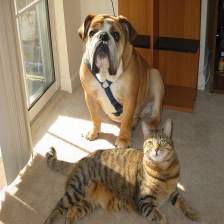

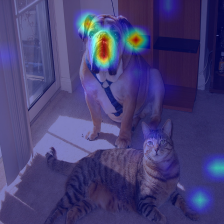

-1

In [ ]:
# cv2.imshow("Input Image", np_img)
cv2_imshow(np_img)
# cv2.imshow(name, mask)
cv2_imshow(mask)
cv2.imwrite("input.png", np_img)
cv2.imwrite(name, mask)
cv2.waitKey(-1)

##Show Swin

In [ ]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [ ]:
from google.colab.patches import cv2_imshow
np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

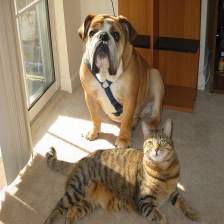

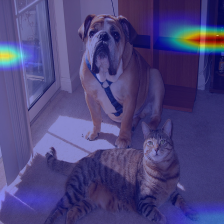

-1

In [ ]:
# cv2.imshow("Input Image", np_img)
cv2_imshow(np_img)
# cv2.imshow(name, mask)
cv2_imshow(mask)
cv2.imwrite("input.png", np_img)
cv2.imwrite(name, mask)
cv2.waitKey(-1)

##Class indicies

In [ ]:
CLS2IDX = {0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'}

##Class predict Swin

In [ ]:
def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

output = modelSwin(input_tensor)
print_top_classes(output)

RuntimeError: ignored

In [ ]:
# all named modules

# patch_embed
# patch_embed.proj
# patch_embed.norm
# pos_drop
# layers
# layers.0
# layers.0.blocks
# layers.0.blocks.0
# layers.0.blocks.0.norm1
# layers.0.blocks.0.attn
# layers.0.blocks.0.attn.qkv
# layers.0.blocks.0.attn.attn_drop
# layers.0.blocks.0.attn.proj
# layers.0.blocks.0.attn.proj_drop
# layers.0.blocks.0.attn.softmax
# layers.0.blocks.0.drop_path
# layers.0.blocks.0.norm2
# layers.0.blocks.0.mlp
# layers.0.blocks.0.mlp.fc1
# layers.0.blocks.0.mlp.act
# layers.0.blocks.0.mlp.fc2
# layers.0.blocks.0.mlp.drop
# layers.0.blocks.1
# layers.0.blocks.1.norm1
# layers.0.blocks.1.attn
# layers.0.blocks.1.attn.qkv
# layers.0.blocks.1.attn.attn_drop
# layers.0.blocks.1.attn.proj
# layers.0.blocks.1.attn.proj_drop
# layers.0.blocks.1.attn.softmax
# layers.0.blocks.1.drop_path
# layers.0.blocks.1.norm2
# layers.0.blocks.1.mlp
# layers.0.blocks.1.mlp.fc1
# layers.0.blocks.1.mlp.act
# layers.0.blocks.1.mlp.fc2
# layers.0.blocks.1.mlp.drop
# layers.0.downsample
# layers.0.downsample.reduction
# layers.0.downsample.norm
# layers.1
# layers.1.blocks
# layers.1.blocks.0
# layers.1.blocks.0.norm1
# layers.1.blocks.0.attn
# layers.1.blocks.0.attn.qkv
# layers.1.blocks.0.attn.attn_drop
# layers.1.blocks.0.attn.proj
# layers.1.blocks.0.attn.proj_drop
# layers.1.blocks.0.attn.softmax
# layers.1.blocks.0.drop_path
# layers.1.blocks.0.norm2
# layers.1.blocks.0.mlp
# layers.1.blocks.0.mlp.fc1
# layers.1.blocks.0.mlp.act
# layers.1.blocks.0.mlp.fc2
# layers.1.blocks.0.mlp.drop
# layers.1.blocks.1
# layers.1.blocks.1.norm1
# layers.1.blocks.1.attn
# layers.1.blocks.1.attn.qkv
# layers.1.blocks.1.attn.attn_drop
# layers.1.blocks.1.attn.proj
# layers.1.blocks.1.attn.proj_drop
# layers.1.blocks.1.attn.softmax
# layers.1.blocks.1.drop_path
# layers.1.blocks.1.norm2
# layers.1.blocks.1.mlp
# layers.1.blocks.1.mlp.fc1
# layers.1.blocks.1.mlp.act
# layers.1.blocks.1.mlp.fc2
# layers.1.blocks.1.mlp.drop
# layers.1.downsample
# layers.1.downsample.reduction
# layers.1.downsample.norm
# layers.2
# layers.2.blocks
# layers.2.blocks.0
# layers.2.blocks.0.norm1
# layers.2.blocks.0.attn
# layers.2.blocks.0.attn.qkv
# layers.2.blocks.0.attn.attn_drop
# layers.2.blocks.0.attn.proj
# layers.2.blocks.0.attn.proj_drop
# layers.2.blocks.0.attn.softmax
# layers.2.blocks.0.drop_path
# layers.2.blocks.0.norm2
# layers.2.blocks.0.mlp
# layers.2.blocks.0.mlp.fc1
# layers.2.blocks.0.mlp.act
# layers.2.blocks.0.mlp.fc2
# layers.2.blocks.0.mlp.drop
# layers.2.blocks.1
# layers.2.blocks.1.norm1
# layers.2.blocks.1.attn
# layers.2.blocks.1.attn.qkv
# layers.2.blocks.1.attn.attn_drop
# layers.2.blocks.1.attn.proj
# layers.2.blocks.1.attn.proj_drop
# layers.2.blocks.1.attn.softmax
# layers.2.blocks.1.drop_path
# layers.2.blocks.1.norm2
# layers.2.blocks.1.mlp
# layers.2.blocks.1.mlp.fc1
# layers.2.blocks.1.mlp.act
# layers.2.blocks.1.mlp.fc2
# layers.2.blocks.1.mlp.drop
# layers.2.blocks.2
# layers.2.blocks.2.norm1
# layers.2.blocks.2.attn
# layers.2.blocks.2.attn.qkv
# layers.2.blocks.2.attn.attn_drop
# layers.2.blocks.2.attn.proj
# layers.2.blocks.2.attn.proj_drop
# layers.2.blocks.2.attn.softmax
# layers.2.blocks.2.drop_path
# layers.2.blocks.2.norm2
# layers.2.blocks.2.mlp
# layers.2.blocks.2.mlp.fc1
# layers.2.blocks.2.mlp.act
# layers.2.blocks.2.mlp.fc2
# layers.2.blocks.2.mlp.drop
# layers.2.blocks.3
# layers.2.blocks.3.norm1
# layers.2.blocks.3.attn
# layers.2.blocks.3.attn.qkv
# layers.2.blocks.3.attn.attn_drop
# layers.2.blocks.3.attn.proj
# layers.2.blocks.3.attn.proj_drop
# layers.2.blocks.3.attn.softmax
# layers.2.blocks.3.drop_path
# layers.2.blocks.3.norm2
# layers.2.blocks.3.mlp
# layers.2.blocks.3.mlp.fc1
# layers.2.blocks.3.mlp.act
# layers.2.blocks.3.mlp.fc2
# layers.2.blocks.3.mlp.drop
# layers.2.blocks.4
# layers.2.blocks.4.norm1
# layers.2.blocks.4.attn
# layers.2.blocks.4.attn.qkv
# layers.2.blocks.4.attn.attn_drop
# layers.2.blocks.4.attn.proj
# layers.2.blocks.4.attn.proj_drop
# layers.2.blocks.4.attn.softmax
# layers.2.blocks.4.drop_path
# layers.2.blocks.4.norm2
# layers.2.blocks.4.mlp
# layers.2.blocks.4.mlp.fc1
# layers.2.blocks.4.mlp.act
# layers.2.blocks.4.mlp.fc2
# layers.2.blocks.4.mlp.drop
# layers.2.blocks.5
# layers.2.blocks.5.norm1
# layers.2.blocks.5.attn
# layers.2.blocks.5.attn.qkv
# layers.2.blocks.5.attn.attn_drop
# layers.2.blocks.5.attn.proj
# layers.2.blocks.5.attn.proj_drop
# layers.2.blocks.5.attn.softmax
# layers.2.blocks.5.drop_path
# layers.2.blocks.5.norm2
# layers.2.blocks.5.mlp
# layers.2.blocks.5.mlp.fc1
# layers.2.blocks.5.mlp.act
# layers.2.blocks.5.mlp.fc2
# layers.2.blocks.5.mlp.drop
# layers.2.downsample
# layers.2.downsample.reduction
# layers.2.downsample.norm
# layers.3
# layers.3.blocks
# layers.3.blocks.0
# layers.3.blocks.0.norm1
# layers.3.blocks.0.attn
# layers.3.blocks.0.attn.qkv
# layers.3.blocks.0.attn.attn_drop
# layers.3.blocks.0.attn.proj
# layers.3.blocks.0.attn.proj_drop
# layers.3.blocks.0.attn.softmax
# layers.3.blocks.0.drop_path
# layers.3.blocks.0.norm2
# layers.3.blocks.0.mlp
# layers.3.blocks.0.mlp.fc1
# layers.3.blocks.0.mlp.act
# layers.3.blocks.0.mlp.fc2
# layers.3.blocks.0.mlp.drop
# layers.3.blocks.1
# layers.3.blocks.1.norm1
# layers.3.blocks.1.attn
# layers.3.blocks.1.attn.qkv
# layers.3.blocks.1.attn.attn_drop
# layers.3.blocks.1.attn.proj
# layers.3.blocks.1.attn.proj_drop
# layers.3.blocks.1.attn.softmax
# layers.3.blocks.1.drop_path
# layers.3.blocks.1.norm2
# layers.3.blocks.1.mlp
# layers.3.blocks.1.mlp.fc1
# layers.3.blocks.1.mlp.act
# layers.3.blocks.1.mlp.fc2
# layers.3.blocks.1.mlp.drop
# norm
# avgpool
# head

In [14]:
!pip -q install torchcam

     |████████████████████████████████| 3.1 MB 18.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [29]:
# https://frgfm.github.io/torch-cam/methods.html
# 
# from torchvision.models import resnet18
# from torchcam.methods import GradCAM, LayerCAM
import torchvision.transforms as T

# cam = LayerCAM(modelSwin, 'layers.3.blocks.0.attn.attn_drop')
# # GradCAM(modelSwin, 'layers.3.blocks.0.attn.attn_drop')
# scores = modelSwin(input_tensor)
# cams = cam(class_idx=243, scores=scores)
# print(cams)




from torchvision.models import resnet18
from torchcam.methods import LayerCAM
extractor = LayerCAM(modelSwin, 'layers.3.blocks.0.attn.attn_drop')
scores = modelSwin(input_tensor)
cams = extractor(class_idx=243, scores=scores)
fused_cam = extractor.fuse_cams(cams)



# define a transform to convert a tensor to PIL image
transform = T.ToPILImage()

# convert the tensor to PIL image using above transform
CAMimg = transform(fused_cam)


#https://frgfm.github.io/torch-cam/utils.html
from torchcam.utils import overlay_mask
overlay = overlay_mask(img, CAMimg)
plt.imshow(overlay) 
plt.show()

ValueError: ignored